In [1]:
import sys
sys.path.append('/home/student/ROI/SparkProgram')
from initspark import *
sc, spark, conf = initspark()

import pandas as pd
import matplotlib as mp
import numpy
from matplotlib import pyplot as plt
from IPython.display import display


In [2]:
filename = 'bank.csv'
df = spark.read.csv(f'/home/student/ROI/Spark/datasets/finance/{filename}', header = True, inferSchema = True)
display(df.limit(10).toPandas())

# Save a pointer to the raw data
df0 = df


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
5,42,management,single,tertiary,no,0,yes,yes,unknown,5,may,562,2,-1,0,unknown,yes
6,56,management,married,tertiary,no,830,yes,yes,unknown,6,may,1201,1,-1,0,unknown,yes
7,60,retired,divorced,secondary,no,545,yes,no,unknown,6,may,1030,1,-1,0,unknown,yes
8,37,technician,married,secondary,no,1,yes,no,unknown,6,may,608,1,-1,0,unknown,yes
9,28,services,single,secondary,no,5090,yes,no,unknown,6,may,1297,3,-1,0,unknown,yes


In [3]:
df0.take(1)

[Row(age=59, job='admin.', marital='married', education='secondary', default='no', balance=2343, housing='yes', loan='no', contact='unknown', day=5, month='may', duration=1042, campaign=1, pdays=-1, previous=0, poutcome='unknown', deposit='yes')]

In [4]:
def drop_columns(df, collist):
    return df.select([c for c in df.columns if c not in collist])

def auto_numeric_features(df, exceptlist = ()):
    numeric_features = [t[0] for t in df.dtypes if t[0] not in exceptlist and t[1] in ['int', 'double']]
    return numeric_features

def auto_categorical_features(df):
    categorical_features = [c for c in df.columns if c.endswith('_ID') or c.endswith('_FLAG')]
    return categorical_features

def describe_numeric_features(df, numeric_features):
    print(df.select(numeric_features).describe().toPandas().transpose())

    
drop_cols = ('day','month')
target_col = 'deposit'
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'campaign','poutcome']

df = drop_columns(df, drop_cols)
numeric_features = auto_numeric_features(df, exceptlist = categorical_features)
print (numeric_features)
print ('*' * 80)
describe_numeric_features(df, numeric_features)
print ('*' * 80)

# save a pointer to the fixed data
df1 = df


['age', 'balance', 'duration', 'pdays', 'previous']
********************************************************************************
              0                   1                   2      3      4
summary   count                mean              stddev    min    max
age       11162  41.231947679627304  11.913369192215518     18     95
balance   11162  1528.5385235620856   3225.413325946149  -6847  81204
duration  11162  371.99381831213043  347.12838571630687      2   3881
pdays     11162   51.33040673714388  108.75828197197717     -1    854
previous  11162  0.8325568894463358   2.292007218670508      0     58
********************************************************************************


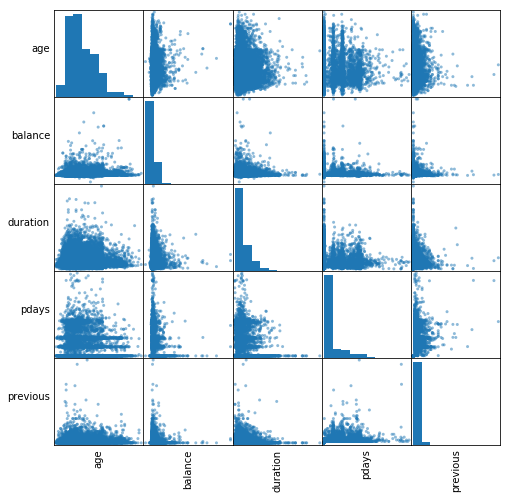

In [5]:
%matplotlib inline
def scatter_matrix(df, numeric_features):
    numeric_data = df.select(numeric_features).toPandas()
    axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
    n = len(numeric_data.columns)
    for i in range(n):
        v = axs[i, 0]
        v.yaxis.label.set_rotation(0)
        v.yaxis.label.set_ha('right')
        v.set_yticks(())
        h = axs[n-1, i]
        h.xaxis.label.set_rotation(90)
        h.set_xticks(())
        
scatter_matrix(df, numeric_features)

In [11]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator
maritalIndexer = StringIndexer(inputCol = 'marital', outputCol = 'maritalIndex')
maritalIndexerFit = maritalIndexer.fit(df.select('marital'))
print(maritalIndexerFit.labels)

encoder = OneHotEncoderEstimator(inputCols=['maritalIndex'], outputCols=['maritalVec'])
pipeline = Pipeline(stages=[maritalIndexer, encoder])
x = pipeline.fit(df.select('marital')).transform(df.select('marital'))
x.show()

def collect_tuple(df):
    return [tuple(row) if len(tuple(row)) > 1 else tuple(row)[0] for row in df.collect()]

def collect_dict(df):
    return dict(collect_tuple(df))

print (collect_tuple(x.select('marital', 'maritalIndex').distinct()))
print (collect_dict(x.select('marital', 'maritalIndex').distinct()))


['married', 'single', 'divorced']
+--------+------------+-------------+
| marital|maritalIndex|   maritalVec|
+--------+------------+-------------+
| married|         0.0|(2,[0],[1.0])|
| married|         0.0|(2,[0],[1.0])|
| married|         0.0|(2,[0],[1.0])|
| married|         0.0|(2,[0],[1.0])|
| married|         0.0|(2,[0],[1.0])|
|  single|         1.0|(2,[1],[1.0])|
| married|         0.0|(2,[0],[1.0])|
|divorced|         2.0|    (2,[],[])|
| married|         0.0|(2,[0],[1.0])|
|  single|         1.0|(2,[1],[1.0])|
|  single|         1.0|(2,[1],[1.0])|
| married|         0.0|(2,[0],[1.0])|
| married|         0.0|(2,[0],[1.0])|
|  single|         1.0|(2,[1],[1.0])|
|  single|         1.0|(2,[1],[1.0])|
|divorced|         2.0|    (2,[],[])|
|  single|         1.0|(2,[1],[1.0])|
| married|         0.0|(2,[0],[1.0])|
| married|         0.0|(2,[0],[1.0])|
|divorced|         2.0|    (2,[],[])|
+--------+------------+-------------+
only showing top 20 rows

[('married', 0.0), ('divorce

In [ ]:
def fix_categorical_data(df, categorical_features, target_col):
    from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler, StringIndexerModel
    from pyspark.ml import Pipeline

    stages = []

    for c in categorical_features:
        stringIndexer = StringIndexer(inputCol = c, outputCol = c + '_Index')
        encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[c + "_classVec"])
        stages += [stringIndexer, encoder]

    label_stringIdx = StringIndexer(inputCol = target_col, outputCol = 'label')
    stages += [label_stringIdx]

    assemblerInputs = [c + "_classVec" for c in categorical_features] + numeric_features
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
    stages += [assembler]

    cols = df.columns
    pipeline = Pipeline(stages = stages)
    pipelineModel = pipeline.fit(df)
    dfx = pipelineModel.transform(df)
    
    dfx = dfx.select(['label', 'features'] + cols)
    catindexes = {x.getOutputCol() : x.labels for x in pipelineModel.stages if isinstance(x, StringIndexerModel)}
    return dfx, catindexes

df, x = fix_categorical_data(df, categorical_features, target_col)
# save a pointer to this stage of the dataframe
df2 = df

df.printSchema()
print (x)

In [ ]:
#for c in df.schema.fields if c.name.endswith
df.groupBy('label').count().show()


In [ ]:
pd.DataFrame(df.take(5), columns = df.columns).transpose()

In [ ]:
train, test = df.randomSplit([.7,.3], seed = 1000)
print (f'Training set row count {train.count()}')
print (f'Testing set row count {test.count()}')
      

In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)
print('LR Trained')
lrModel.save('bank_LR.trainedModel')

In [ ]:
def beta_coefficients(model):
    import matplotlib.pyplot as plt
    import numpy as np
    beta = np.sort(model.coefficients)
    plt.plot(beta)
    plt.ylabel('Beta Coefficients')
    plt.show()
    
beta_coefficients(lrModel)

In [ ]:
def roc_curve(model):
    summary = model.summary
    roc = summary.roc.toPandas()
    plt.plot(roc['FPR'],roc['TPR'])
    plt.ylabel('False Positive Rate')
    plt.xlabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    print('Training set area Under ROC: {}'.format(summary.areaUnderROC))

roc_curve(lrModel)

In [ ]:
def precision_recall(model):
    summary = model.summary
    pr = summary.pr.toPandas()
    plt.plot(pr['recall'],pr['precision'])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()

precision_recall(lrModel)    

In [ ]:
def evaluate_ROC(predictions):
    from pyspark.ml.evaluation import BinaryClassificationEvaluator
    evaluator = BinaryClassificationEvaluator()
    return evaluator.evaluate(predictions)

def show_predictions(predictions, limit = 20):
    print('Test Area Under ROC {}'.format(evaluate_ROC(predictions)))
    predictions.groupBy('prediction').count().show()
    predictions.select('label', 'rawPrediction', 'prediction', 'probability').show(limit)



predictions = lrModel.transform(test)
show_predictions(predictions)


In [ ]:

print (collect_tuple(predictions.select('prediction').distinct()))

def cm_percent(cm, length, legend = True):
    import numpy as np
    x = np.ndarray(shape = (2,2), \
                      buffer = np.array([100 *(cm[0][0] + cm[1][1])/length, \
                      100 * cm[0][1]/length, 100 * cm[1][0]/length, \
                      100 * (cm[1][0] + cm[0][1])/length]))
    return x



In [ ]:
def evaluate_model(model):
    beta_coefficients(lrModel)
    roc_curve(lrModel)
    precision_recall(lrModel)    

def evaluate_predictions(predictions, show = True):
    from pyspark.ml.evaluation import BinaryClassificationEvaluator
    from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
    log = {}

    evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
    log['auroc'] = evaluator.evaluate(predictions)  
    
    # Show Validation Score (AUPR)
    evaluator = BinaryClassificationEvaluator(metricName='areaUnderPR')
    log['aupr'] = evaluator.evaluate(predictions)

    # Metrics
    predictionRDD = predictions.select(['label', 'prediction']) \
                   .rdd.map(lambda line: (line[1], line[0]))
    metrics = MulticlassMetrics(predictionRDD)
    

    # Overall statistics
    log['precision'] = metrics.precision()
    log['recall'] = metrics.recall()
    log['F1 Measure'] = metrics.fMeasure()
    
    # Statistics by class
    distinctPredictions = collect_tuple(predictions.select('prediction').distinct())
    for x in sorted(distinctPredictions):
        log[x] = {}
        log[x]['precision'] = metrics.precision(x)
        log[x]['recall'] = metrics.recall(x)
        log[x]['F1 Measure'] = metrics.fMeasure(x, beta = 1.0)

    # Confusion Matrix
    log['cm'] = metrics.confusionMatrix().toArray()
    log['cmpercent'] = cm_percent(log['cm'], predictions.count(), show)

    if show:
        show_predictions(predictions)

        print("Area under ROC = {}".format(log['auroc']))
        print("Area under AUPR = {}".format(log['aupr']))
        print('\nOverall\ntprecision = {}\nrecall = {}\nF1 Measure = {}\n'.format( 
              log['precision'], log['recall'], log['F1 Measure']))

        for x in sorted(distinctPredictions):
            print('Label {}\ntprecision = {}\nrecall = {}\nF1 Measure = {}\n'.format( 
                  x, log[x]['precision'], log[x]['recall'], log[x]['F1 Measure']))
        
        print ('Confusion Matrix')
        print (log['cm'])
        print (' PC', 'FP\n', 'FN', 'PW')
        print (log['cmpercent'])

    return log    


log = evaluate_predictions(predictions)
print ()
print (log)